Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from sklearn.manifold import TSNE

from gpytorch.kernels import MaternKernel
from gpytorch.priors import GammaPrior

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/ubuntu/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

In [3]:
## Load existing data

In [4]:
with open('../80nmTarget_round2/constants_Round2_2025_01_28.json', 'rt') as f:
    synth_constants = json.load(f) 

In [5]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [6]:
synth_data = pd.read_csv('synth_table_Round2_opt2_80nm.csv')
synth_data = synth_data[~synth_data['ap_distance'].isna()]
#synth_data = synth_data[synth_data['ap_distance'] < 8]

In [7]:
synth_data

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,well,campaign,...,dilute_well,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,rmse_distance,experiment_status,rank
0,c563cb4d-d727-437f-9a6a-fef3eccbbe50,222.617091,399.058218,590.750129,487.574561,0.485800,12.367236,0.014890,A1,Round2Random,...,NaN,1700.0,0.045948,0.082365,0.121930,0.286809,1.522190,0.255116,complete,26.0
1,3ef8b92f-f2eb-4134-ad6c-ae3329408457,424.578425,225.592744,374.598586,675.230244,0.254717,23.586966,0.028651,A2,Round2Random,...,NaN,1700.0,0.087632,0.046562,0.077317,0.397194,1.548249,0.264217,complete,40.0
2,0507cf19-673b-4d6b-922e-c21f718ad4fe,290.225034,259.039405,534.588398,616.147162,0.372633,16.123118,0.019498,A3,Round2Random,...,NaN,1700.0,0.059902,0.053465,0.110338,0.362440,1.489590,0.254219,complete,20.0
3,82fc5e1c-5d6e-4ecd-82c3-eb912535a0d7,87.221241,134.097491,46.585717,1432.095551,1.239920,4.845476,0.006080,A4,Round2Random,...,NaN,1700.0,0.018002,0.027678,0.009615,0.842409,0.991199,0.298204,complete,1.0
4,9964ab9f-5b01-4ae2-b492-a1be55ce083f,44.198312,353.311589,274.447630,1028.042468,2.446865,2.455386,0.003029,A5,Round2Random,...,NaN,1700.0,0.009122,0.072923,0.056646,0.604731,1.429035,0.302280,complete,11.0
5,d263a9a8-70c2-49a4-badb-03a72fa16632,362.014946,39.599052,668.974648,629.411354,0.298737,20.111324,0.024235,A6,Round2Random,...,NaN,1700.0,0.074719,0.008173,0.138075,0.370242,1.506382,0.314632,complete,23.0
6,586ae478-4dab-4d7d-9382-ab359a49387a,467.857264,437.608025,146.758782,647.775928,0.231155,25.991272,0.031714,A7,Round2Random,...,NaN,1700.0,0.096565,0.090322,0.030291,0.381045,2.237381,1.856282,complete,51.5
7,7386215f-7150-48a6-b35f-96cbe5b743cf,150.571271,186.816687,456.385989,906.226053,0.718247,8.364814,0.010229,A8,Round2Random,...,NaN,1700.0,0.031078,0.038559,0.094197,0.533074,1.536987,0.259520,complete,32.0
8,d408858a-bbae-4227-8e64-6c368a1f3398,171.120992,296.220804,158.477050,1074.181154,0.631993,9.506430,0.011766,B1,Round2Random,...,NaN,1700.0,0.035319,0.061139,0.032709,0.631871,1.533968,0.256223,complete,30.0
9,0c042bd5-e5ed-4460-9bb9-d8556dba293c,429.271862,97.506840,378.830708,794.390591,0.251932,23.847704,0.029060,B3,Round2Random,...,NaN,1700.0,0.088601,0.020125,0.078190,0.467289,1.560358,0.258701,complete,45.0


Text(0, 0.5, 'AP distance')

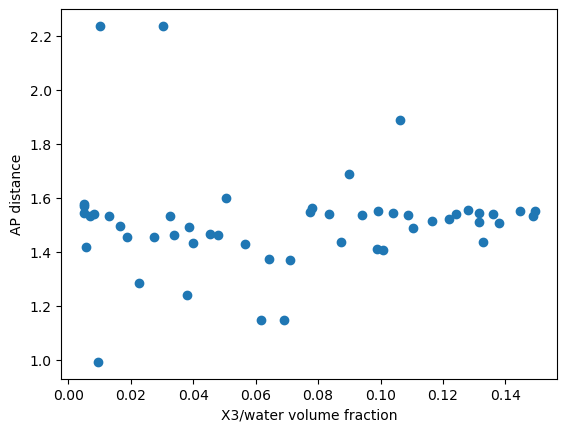

In [8]:
plt.scatter(synth_data['water_vol_frac'], synth_data['ap_distance'])
plt.xlabel('X3/water volume fraction')
plt.ylabel('AP distance')

In [9]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = - synth_data['ap_distance']
y_data = torch.tensor(y_data.to_numpy()).reshape(-1,1)

In [10]:
y_data.min()

tensor(-2.2374, dtype=torch.float64)

## data pre-processing

In [11]:
y_data_norm = normalize(y_data, (y_data.min(), y_data.max())).reshape(-1,1)

In [12]:
bounds_torch_norm = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [13]:
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

In [14]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [15]:
x_data_norm = normalize(x_data_torch, bounds_torch_norm)

## Visualize design space

In [16]:
## Concentrations

In [17]:
x_data_norm[:,0]

tensor([ 4.3103e-01,  8.6981e-01,  5.7792e-01,  1.3687e-01,  4.3394e-02,
         7.3389e-01,  9.6384e-01,  2.7450e-01,  3.1915e-01,  8.8001e-01,
         6.7221e-01,  1.1301e-01,  2.0703e-01,  5.1569e-01,  7.8653e-01,
         4.7513e-01,  4.5524e-01,  7.6735e-01,  5.3587e-01,  2.2591e-01,
         6.9439e-02,  6.2984e-01,  9.2339e-01,  3.6171e-01,  2.9466e-01,
         9.8274e-01,  7.1404e-01,  2.4181e-02,  1.8022e-01,  6.2050e-01,
         8.2628e-01,  3.8862e-01,  1.6560e-01,  5.1097e-02,  5.9412e-01,
         3.0611e-01,  1.2876e-01,  1.0838e-01,  1.4607e-01,  4.4760e-01,
         9.1955e-01,  4.1961e-02,  1.0719e-01,  1.7992e-01,  8.7177e-02,
         6.1181e-01,  5.8800e-01,  5.2684e-01,  6.4477e-01, -9.5866e-16,
         1.3456e-01,  7.2200e-01], dtype=torch.float64)

In [18]:
best_10_ind = torch.argsort(y_data_norm, dim = 0, descending = True)[0:10].reshape(-1)

In [19]:
best_10_ind

tensor([ 3, 41, 15, 49, 20, 24, 22, 45, 12, 36])

In [20]:
X_best10 = x_data_norm[best_10_ind,:]

In [21]:
X_best10.shape

torch.Size([10, 3])

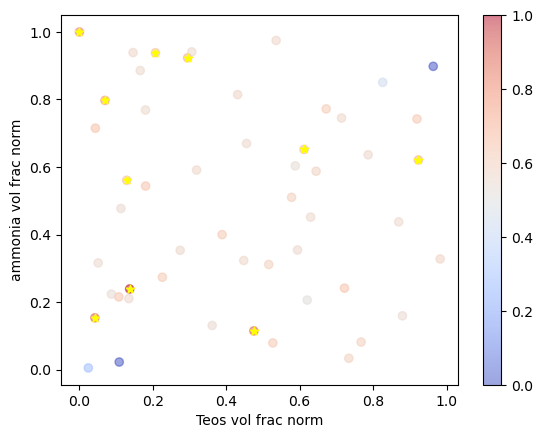

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,1], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('ammonia vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,1], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

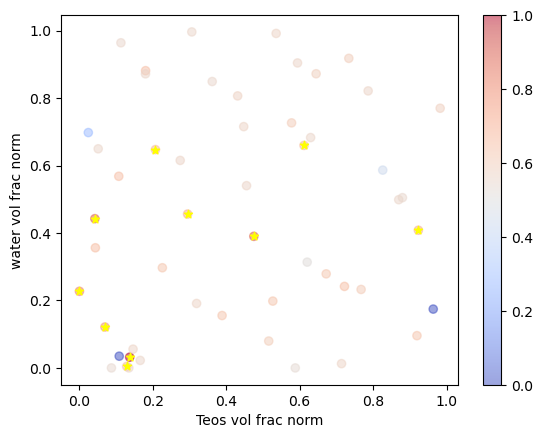

In [23]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,2], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('water vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,2], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

In [24]:
### TSNE rep

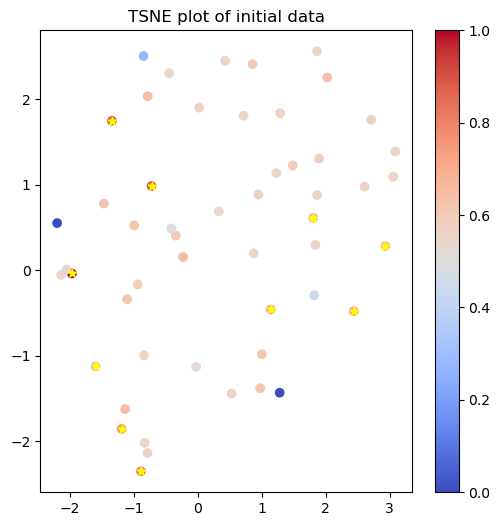

In [25]:

tsne = TSNE()

x_tsne_og = tsne.fit_transform(x_data_norm)

x_tsne_bestn = x_tsne_og[best_10_ind,:]

fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data_norm, cmap = plt.cm.coolwarm)

ax.scatter(x_tsne_bestn[:,0], x_tsne_bestn[:,1], marker = '*', c = 'yellow')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Set up BO things

In [26]:
#bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype)

BATCH_SIZE = 10  if not SMOKE_TEST else 2
NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 210 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data
assumed_noise = 5e-2

In [27]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = ard_num_dims)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        #train_Yvar=assumed_noise*torch.ones_like(train_y),
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [28]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [29]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y, ard_num_dims = ard_num_dims)

t0 = time.monotonic()

# fit the models

fit_mll = fit_gpytorch_mll(mll_nei)





In [30]:
fit_mll.model

SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
  (input_transform): Normalize()
)

In [31]:
posterior = model_nei.posterior(train_x)
mean = np.array(posterior.mean.detach().reshape(-1))
std = np.array(posterior.stddev.detach().reshape(-1))

In [32]:
std.shape

(52,)

Text(0, 0.5, 'Predicted scaled distance')

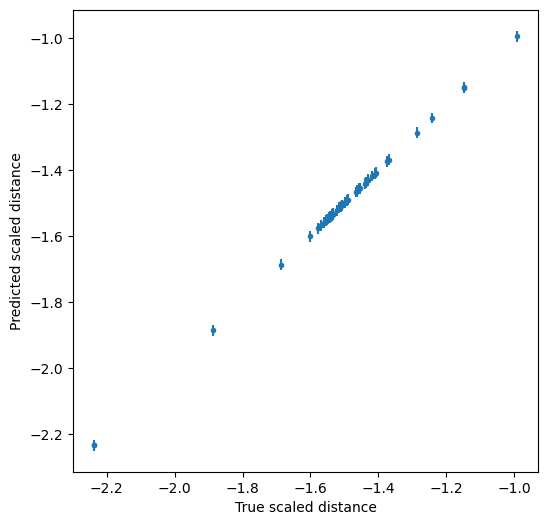

In [33]:
fig, ax = plt.subplots(figsize = (6,6))

ax.errorbar(np.array(train_y), mean, yerr = std, linestyle = '', marker = '.')
#ax.plot(train_y, train_y)
ax.set_xlabel('True scaled distance')
ax.set_ylabel('Predicted scaled distance')

Text(0, 0.5, 'AP distance')

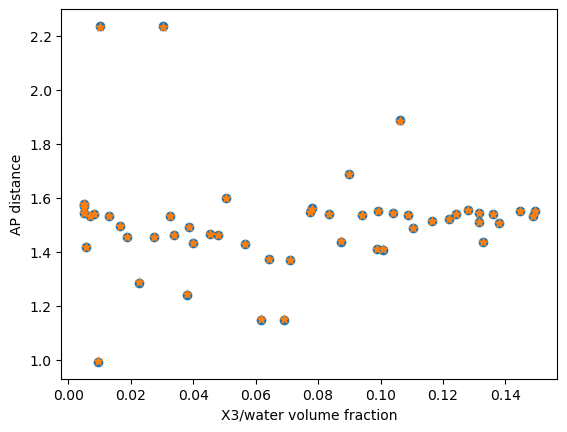

In [34]:
plt.scatter(synth_data['water_vol_frac'], synth_data['ap_distance'])
plt.scatter(synth_data['water_vol_frac'], -1*mean, marker = '*')
plt.xlabel('X3/water volume fraction')
plt.ylabel('AP distance')

In [35]:
for param_name, param in model_nei.named_parameters():
    print(f'Parameter name: {param_name} value = {param.tolist()}')

Parameter name: likelihood.noise_covar.raw_noise value = [0.006837044231220404]
Parameter name: mean_module.raw_constant value = -0.02034937935395906
Parameter name: covar_module.raw_lengthscale value = [[-2.2653075092180224, -4.717640668252917, 6.874383349749172]]


In [36]:
model_nei.covar_module.lengthscale

tensor([[0.0988, 0.0089, 6.8754]], dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)

(array([ 2.,  0.,  1.,  0.,  1., 28., 15.,  2.,  2.,  1.]),
 array([-2.23738135, -2.11276311, -1.98814488, -1.86352664, -1.73890841,
        -1.61429018, -1.48967194, -1.36505371, -1.24043547, -1.11581724,
        -0.99119901]),
 <BarContainer object of 10 artists>)

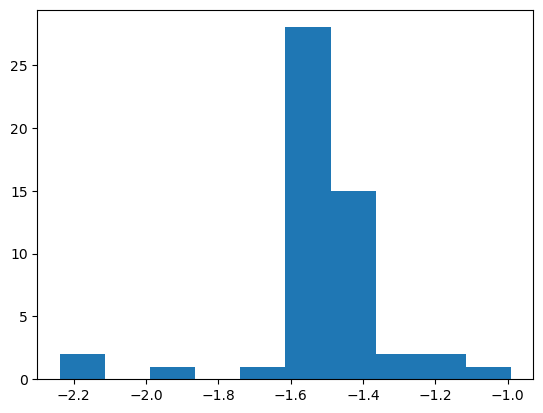

In [37]:
plt.hist(train_y)

In [38]:
# define the qEI and qNEI acquisition modules using a QMC sampler
t_acqf = time.time()
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True,
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch_opt,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)
print(f'Optimized acqf in {time.time() - t_acqf} s')

Optimized acqf in 69.00822305679321 s


In [39]:
candidates

tensor([[0.6442, 0.2885, 0.1767],
        [0.1714, 0.2396, 0.5942],
        [0.1189, 0.2414, 0.6287],
        [0.1397, 0.6462, 0.7178],
        [0.0521, 0.1604, 0.8594],
        [1.0000, 0.6333, 0.6244],
        [0.2969, 0.4213, 0.0803],
        [0.8249, 0.9051, 0.1867],
        [0.0266, 0.1462, 0.2680],
        [0.8722, 0.6074, 0.1962]])

## Visualize model predictions

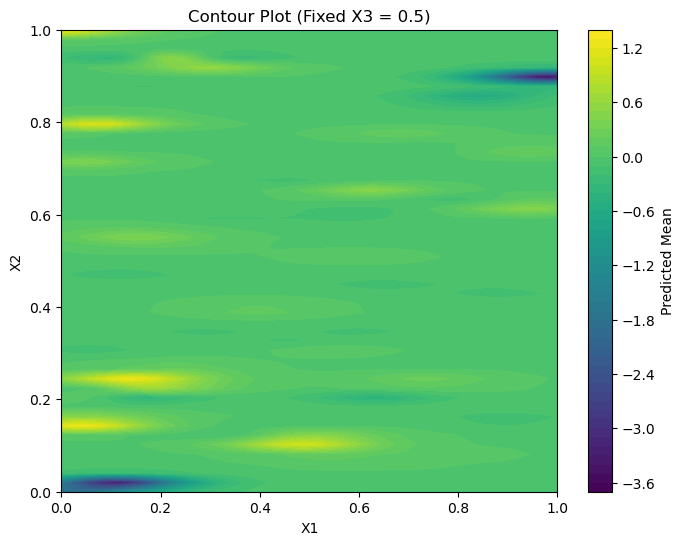

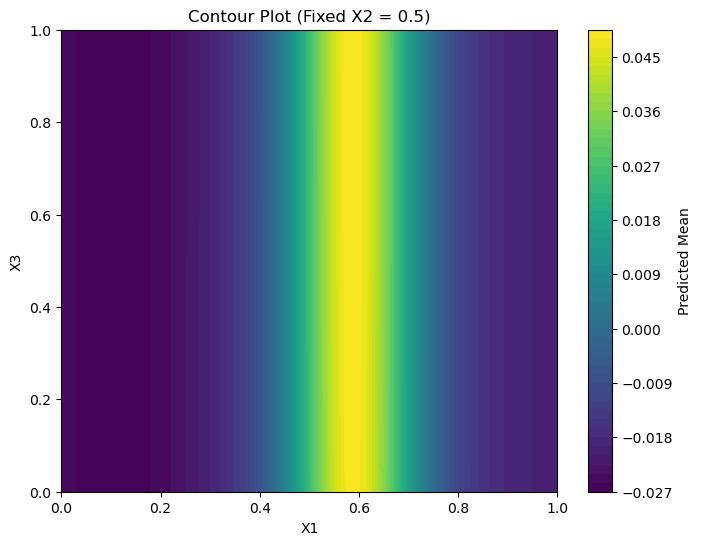

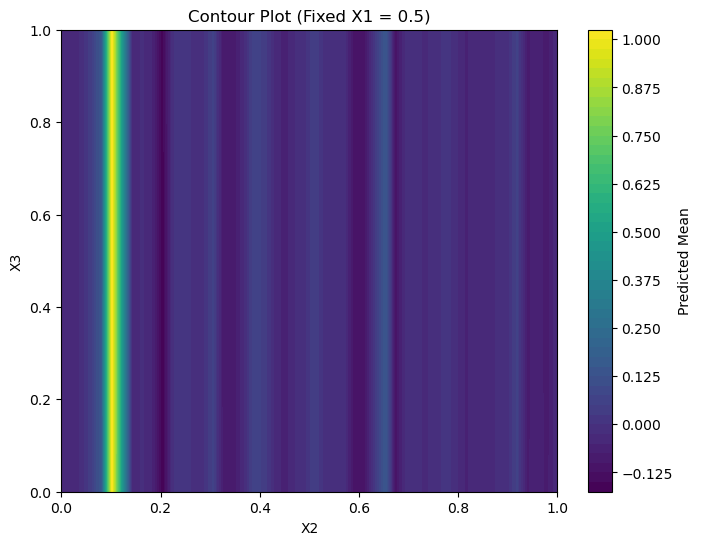

In [40]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")


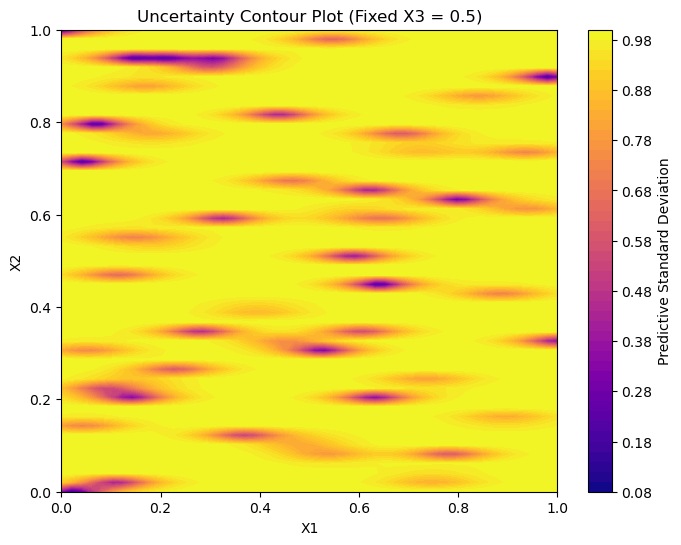

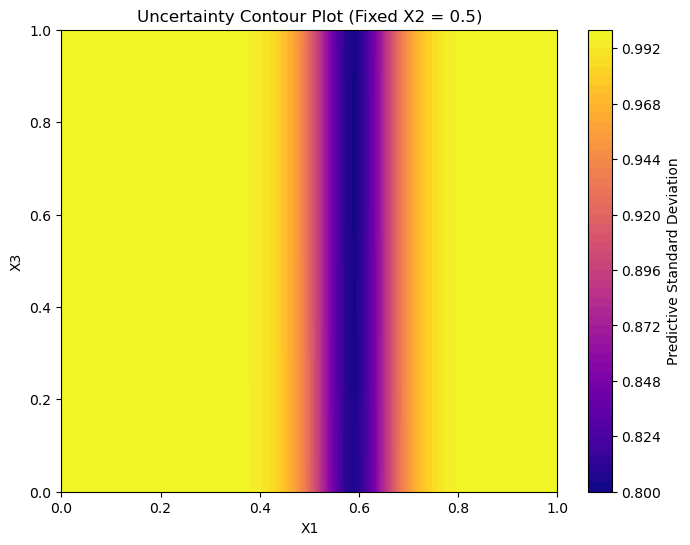

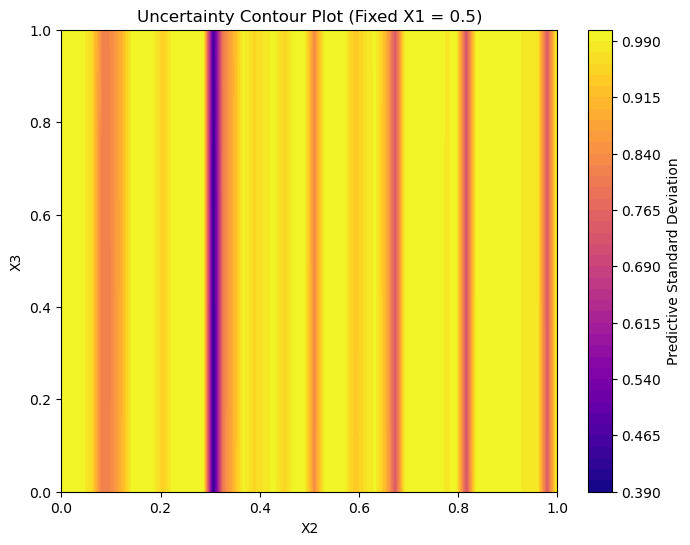

In [41]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for uncertainty
def plot_contour_uncertainty(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model to get uncertainty (standard deviation)
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        std_dev = preds.variance.sqrt().numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour of uncertainty
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, std_dev, levels=50, cmap="plasma")  # Plasma color map for uncertainty
    plt.colorbar(cp, label="Predictive Standard Deviation")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of uncertainty by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                         x_range=x, y_range=y, 
                         dim_labels=["X1", "X2"], 
                         title="Uncertainty Contour Plot (Fixed X3 = 0.5)")

# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                         x_range=x, y_range=z, 
                         dim_labels=["X1", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                         x_range=y, y_range=z, 
                         dim_labels=["X2", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X1 = 0.5)")

## ACQ func value

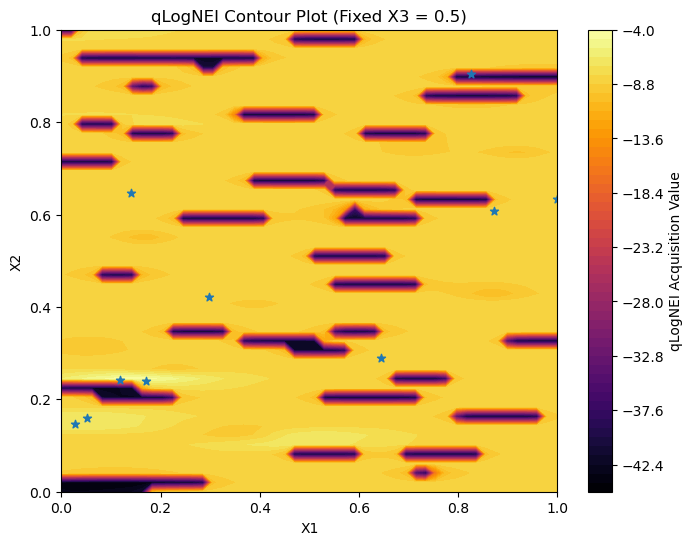

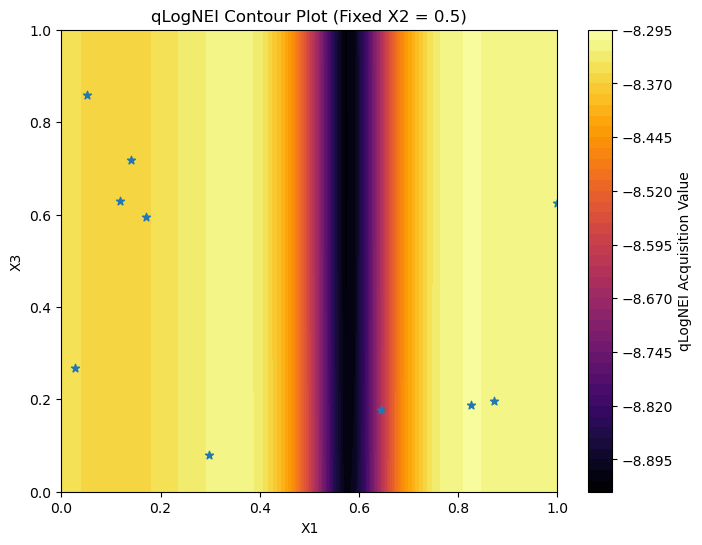

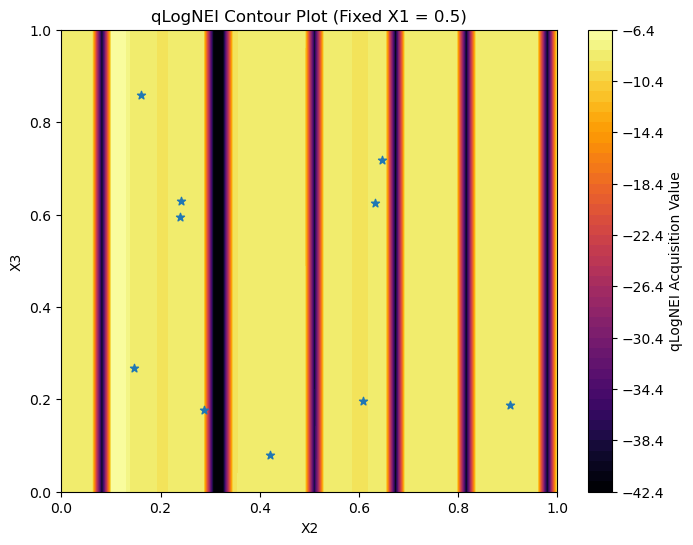

In [42]:
acq_func = qLogNEI
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of qLogNEI by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=2, fixed_val=fixed_vals[2], 
                     x_range=x, y_range=y, 
                     dim_labels=["X1", "X2"], 
                     title="qLogNEI Contour Plot (Fixed X3 = 0.5)", candidates =  candidates)

# Slice along X1 and X3, fixing X2 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=1, fixed_val=fixed_vals[1], 
                     x_range=x, y_range=z, 
                     dim_labels=["X1", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X2 = 0.5)", candidates = candidates)

# Slice along X2 and X3, fixing X1 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=0, fixed_val=fixed_vals[0], 
                     x_range=y, y_range=z, 
                     dim_labels=["X2", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X1 = 0.5)", candidates = candidates)


## Visualize new batch

In [43]:
tsne = TSNE()

In [44]:
x_data_norm.shape

torch.Size([52, 3])

In [45]:
all_x = torch.cat([x_data_norm, candidates])

In [46]:
x_tsne_og = tsne.fit_transform(all_x)

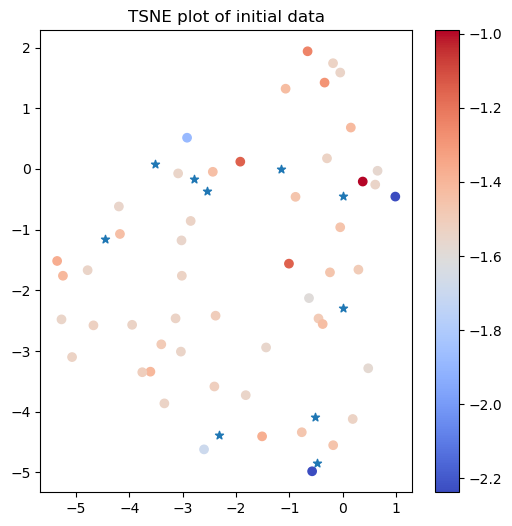

In [47]:
fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = train_y, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Prep new sample table for next experiment

In [48]:
x_fractions = unnormalize(candidates, bounds_torch_norm)

In [49]:
x_fractions

tensor([[0.0662, 0.0324, 0.0306],
        [0.0213, 0.0278, 0.0912],
        [0.0163, 0.0279, 0.0962],
        [0.0183, 0.0664, 0.1091],
        [0.0100, 0.0202, 0.1296],
        [0.1000, 0.0652, 0.0955],
        [0.0332, 0.0450, 0.0166],
        [0.0834, 0.0910, 0.0321],
        [0.0075, 0.0189, 0.0439],
        [0.0879, 0.0627, 0.0335]])

In [50]:
target_volume = 1700
target_dilution = 0.1 # mol Si/L saxs sample
constants_fp = './constants_Round2_2025_01_28.json'
samples_write_fp = 'Sample_table_2025_02_03_80nm_Round3_apdist.csv'


In [51]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

406.41211181879044
440.9271613880992
441.53702802956104
609.3022916279733
502.5812003482133
819.9093804508448
298.35519889369607
649.178775921464
221.01847275625914
578.7420375458896


In [52]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [53]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction
0,f0760849-19ea-4064-b5ae-e45aa981996e,320.743094,157.000638,148.350603,1073.905666,0.337177,17.818514,0.022030
1,f3cbf509-261b-412c-b083-ea00cf8edf39,103.100598,134.489344,441.676225,1020.733832,1.048950,5.727635,0.007032
2,8331bed0-257f-42ce-b6e0-439b92c237c6,78.933306,135.352268,465.920118,1019.794308,1.370110,4.385049,0.005381
3,bd07bf5f-b860-4d60-bb06-8bcf078973cd,88.504707,321.646809,528.503366,761.345118,1.221939,4.916777,0.005981
4,d25c4916-b521-497c-b864-cf91a0aea475,48.228321,98.034325,627.984068,925.753286,2.242403,2.679269,0.003267
5,311ef7f0-67f0-44f1-8b30-14f89070d209,484.500007,315.698101,462.905532,436.896360,0.223214,26.915840,0.032393
6,a5099251-1d47-4f19-829a-651f742dde01,160.869123,218.119856,80.639300,1240.371721,0.672269,8.936899,0.011136
7,9c7c4090-d1a8-42e9-9f48-29ea62098dff,403.886571,440.832469,155.367182,699.913778,0.267767,22.437454,0.027427
8,9b4974c6-3261-4669-87d4-17f776c3fbc9,36.462450,91.528101,212.497366,1359.512083,2.965992,2.025629,0.002527
9,6294633a-9219-4287-8b6b-86d972f53cc8,425.698537,303.783538,162.093497,808.424429,0.254047,23.649192,0.028986


In [54]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [55]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [56]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [57]:
synth_table['well'] = wells[:len(synth_table)]


In [58]:
synth_table['dilute_well'] = wells[2*len(synth_table):3*len(synth_table)]

## Visualize new batch

In [59]:
synth_data['rank'] = synth_data['ap_distance'].rank()

In [60]:
best_row = synth_data.iloc[synth_data['ap_distance'].argmin()]

In [61]:
best10 = synth_data.iloc[synth_data['rank'].argsort().iloc[:10]]

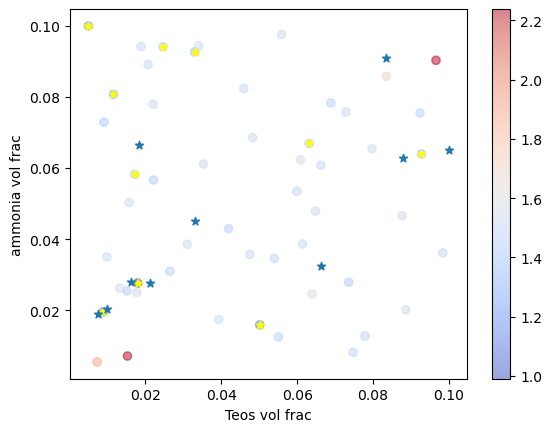

In [62]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('ammonia vol frac')


ax.scatter(best10['teos_vol_frac'], best10['ammonia_vol_frac'], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(synth_table['teos_volume']/target_volume/synth_constants['TEOS']['dilution_ratio'], synth_table['ammonia_volume']/target_volume/synth_constants['ammonia']['dilution_ratio'], marker = '*')

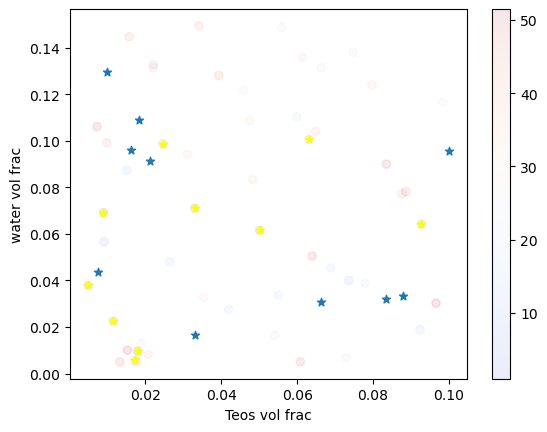

In [63]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['water_vol_frac'], c = synth_data['rank'], cmap = plt.cm.coolwarm, alpha=0.1)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('water vol frac')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(best10['teos_vol_frac'], best10['water_vol_frac'], marker = '*', color = 'yellow')

ax.scatter(synth_table['teos_volume']/target_volume/synth_constants['TEOS']['dilution_ratio'], synth_table['water_volume']/target_volume/synth_constants['water']['dilution_ratio'], marker = '*')

In [64]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,well,dilute_well
0,f0760849-19ea-4064-b5ae-e45aa981996e,320.743094,157.000638,148.350603,1073.905666,0.337177,17.818514,0.022030,1127.0,573.0,A1,C7
1,f3cbf509-261b-412c-b083-ea00cf8edf39,103.100598,134.489344,441.676225,1020.733832,1.048950,5.727635,0.007032,0.0,1700.0,A2,C8
2,8331bed0-257f-42ce-b6e0-439b92c237c6,78.933306,135.352268,465.920118,1019.794308,1.370110,4.385049,0.005381,0.0,1700.0,A3,D1
3,bd07bf5f-b860-4d60-bb06-8bcf078973cd,88.504707,321.646809,528.503366,761.345118,1.221939,4.916777,0.005981,0.0,1700.0,A4,D2
4,d25c4916-b521-497c-b864-cf91a0aea475,48.228321,98.034325,627.984068,925.753286,2.242403,2.679269,0.003267,0.0,1700.0,A5,D3
5,311ef7f0-67f0-44f1-8b30-14f89070d209,484.500007,315.698101,462.905532,436.896360,0.223214,26.915840,0.032393,1321.0,379.0,A6,D4
6,a5099251-1d47-4f19-829a-651f742dde01,160.869123,218.119856,80.639300,1240.371721,0.672269,8.936899,0.011136,557.0,1143.0,A7,D5
7,9c7c4090-d1a8-42e9-9f48-29ea62098dff,403.886571,440.832469,155.367182,699.913778,0.267767,22.437454,0.027427,1245.0,455.0,A8,D6
8,9b4974c6-3261-4669-87d4-17f776c3fbc9,36.462450,91.528101,212.497366,1359.512083,2.965992,2.025629,0.002527,0.0,1700.0,B1,D7
9,6294633a-9219-4287-8b6b-86d972f53cc8,425.698537,303.783538,162.093497,808.424429,0.254047,23.649192,0.028986,1268.0,432.0,B3,D8


In [65]:
x_fractions

tensor([[0.0662, 0.0324, 0.0306],
        [0.0213, 0.0278, 0.0912],
        [0.0163, 0.0279, 0.0962],
        [0.0183, 0.0664, 0.1091],
        [0.0100, 0.0202, 0.1296],
        [0.1000, 0.0652, 0.0955],
        [0.0332, 0.0450, 0.0166],
        [0.0834, 0.0910, 0.0321],
        [0.0075, 0.0189, 0.0439],
        [0.0879, 0.0627, 0.0335]])

In [66]:
synth_table.to_csv(samples_write_fp)